In [1]:
%matplotlib inline


===================================================================
Determining and plotting the altitude/azimuth of a celestial object
===================================================================

This example demonstrates coordinate transformations and the creation of
visibility curves to assist with observing run planning.

In this example, we make a `~astropy.coordinates.SkyCoord` instance for M33.
The altitude-azimuth coordinates are then found using
`astropy.coordinates.EarthLocation` and `astropy.time.Time` objects.

This example is meant to demonstrate the capabilities of the
`astropy.coordinates` package. For more convenient and/or complex observation
planning, consider the `astroplan <https://astroplan.readthedocs.org/>`_
package.

-------------------

*By: Erik Tollerud, Kelle Cruz*

*License: BSD*

-------------------




Let's suppose you are planning to visit picturesque Bear Mountain State Park
in New York, USA. You're bringing your telescope with you (of course), and
someone told you M33 is a great target to observe there. You happen to know
you're free at 11:00 pm local time, and you want to know if it will be up.
Astropy can answer that.

Make print work the same in all versions of Python, set up numpy,
matplotlib, and use a nicer set of plot parameters:



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

Import the packages necessary for finding coordinates and making
coordinate transformations



In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

`astropy.coordinates.SkyCoord.from_name` uses Simbad to resolve object
names and retrieve coordinates.

Get the coordinates of M33:



In [4]:
m33 = SkyCoord.from_name('M33')

Use `astropy.coordinates.EarthLocation` to provide the location of Bear
Mountain and set the time to 11pm EDT on 2012 July 12:



In [5]:
bear_mountain = EarthLocation(lat=41.3*u.deg, lon=-74*u.deg, height=390*u.m)
utcoffset = -4*u.hour  # Eastern Daylight Time
time = Time('2012-7-12 23:00:00') - utcoffset

`astropy.coordinates.EarthLocation.get_site_names` and
`~astropy.coordinates.EarthLocation.get_site_names` can be used to get
locations of major observatories.

Use `astropy.coordinates` to find the Alt, Az coordinates of M33 at as
observed from Bear Mountain at 11pm on 2012 July 12.



In [6]:
m33altaz = m33.transform_to(AltAz(obstime=time,location=bear_mountain))
print("M33's Altitude = {0.alt:.2}".format(m33altaz))

M33's Altitude = 0.13 deg


This is helpful since it turns out M33 is barely above the horizon at this
time. It's more informative to find M33's airmass over the course of
the night.

Find the alt,az coordinates of M33 at 100 times evenly spaced between 10pm
and 7am EDT:



In [7]:
midnight = Time('2012-7-13 00:00:00') - utcoffset
delta_midnight = np.linspace(-2, 10, 100)*u.hour
frame_July13night = AltAz(obstime=midnight+delta_midnight,
                          location=bear_mountain)
m33altazs_July13night = m33.transform_to(frame_July13night)

convert alt, az to airmass with `~astropy.coordinates.AltAz.secz` attribute:



In [8]:
m33airmasss_July13night = m33altazs_July13night.secz

Plot the airmass as a function of time:



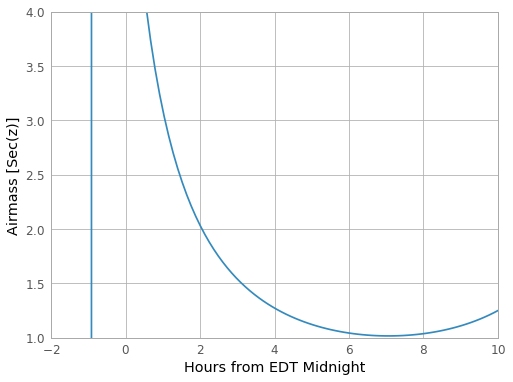

In [9]:
plt.plot(delta_midnight, m33airmasss_July13night)
plt.xlim(-2, 10)
plt.ylim(1, 4)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Airmass [Sec(z)]')
plt.show()

Use  `~astropy.coordinates.get_sun` to find the location of the Sun at 1000
evenly spaced times between noon on July 12 and noon on July 13:



In [10]:
from astropy.coordinates import get_sun
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times_July12_to_13 = midnight + delta_midnight
frame_July12_to_13 = AltAz(obstime=times_July12_to_13, location=bear_mountain)
sunaltazs_July12_to_13 = get_sun(times_July12_to_13).transform_to(frame_July12_to_13)

Do the same with `~astropy.coordinates.get_moon` to find when the moon is
up. Be aware that this will need to download a 10MB file from the internet
to get a precise location of the moon.



In [11]:
from astropy.coordinates import get_moon
moon_July12_to_13 = get_moon(times_July12_to_13)
moonaltazs_July12_to_13 = moon_July12_to_13.transform_to(frame_July12_to_13)

Find the alt,az coordinates of M33 at those same times:



In [12]:
m33altazs_July12_to_13 = m33.transform_to(frame_July12_to_13)

Make a beautiful figure illustrating nighttime and the altitudes of M33 and
the Sun over that time:



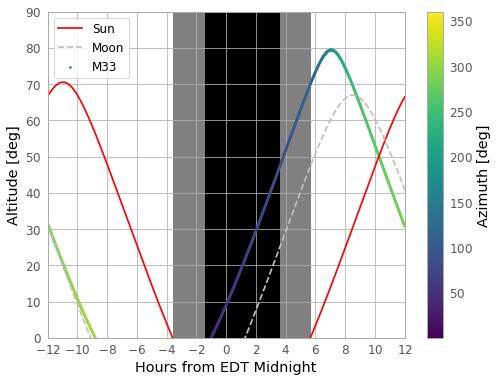

In [13]:
plt.plot(delta_midnight, sunaltazs_July12_to_13.alt, color='r', label='Sun')
plt.plot(delta_midnight, moonaltazs_July12_to_13.alt, color=[0.75]*3, ls='--', label='Moon')
plt.scatter(delta_midnight, m33altazs_July12_to_13.alt,
            c=m33altazs_July12_to_13.az, label='M33', lw=0, s=8,
            cmap='viridis')
plt.fill_between(delta_midnight.to('hr').value, 0, 90,
                 sunaltazs_July12_to_13.alt < -0*u.deg, color='0.5', zorder=0)
plt.fill_between(delta_midnight.to('hr').value, 0, 90,
                 sunaltazs_July12_to_13.alt < -18*u.deg, color='k', zorder=0)
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc='upper left')
plt.xlim(-12, 12)
plt.xticks(np.arange(13)*2 -12)
plt.ylim(0, 90)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Altitude [deg]')
plt.show()